# Set up a rectangular regional CESM-MOM6 run

A typical workflow of utilizing CrocoDash consists of four main steps:

1. Generate a regional MOM6 domain.
2. Create the CESM case.
3. Prepare ocean forcing data.
4. Build and run the case.

# SECTION 1: Generate a regional MOM6 domain

We begin by defining a regional MOM6 domain using CrocoDash. To do so, we first generate a horizontal grid. We then generate the topography by remapping an existing bathymetric dataset to our horizontal grid. Finally, we define a vertical grid.

## Step 1.1: Horizontal Grid

In [7]:
from CrocoDash.grid import Grid

grid = Grid(
  resolution = 0.01,
  xstart = 278.0,
  lenx = 1.0,
  ystart = 7.0,
  leny = 1.0,
  name = "panama1",
)

## Step 1.2: Topography

In [8]:
from CrocoDash.topo import Topo

topo = Topo(
    grid = grid,
    min_depth = 9.5,
)

In [9]:
bathymetry_path='/home/manishrv/inputs_rm6/gebco/GEBCO_2024.nc'

topo.interpolate_from_file(
    file_path = bathymetry_path,
    longitude_coordinate_name="lon",
    latitude_coordinate_name="lat",
    vertical_coordinate_name="elevation"
)

Begin regridding bathymetry...

Original bathymetry size: 1.85 Mb
Regridded size: 0.24 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory None via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
setup bathymetry has finished successfully.
Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in inland lakes and channels... 

**TODO:** when the above topo.interpolate_from_file() method is called with the original GEBCO dataset, the interpolation fails do to large computational demand when run on login nodes. Check if there is a failsafe way, or at least, a means to precaution the user.

**TODO:** Make required data available online (not just on glade).

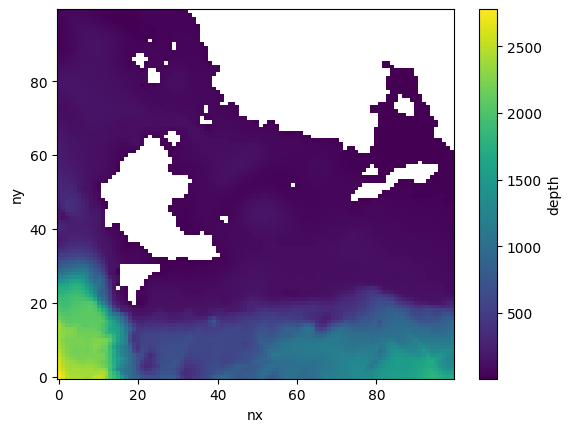

In [10]:
topo.depth.plot()

In [9]:
# Erase Pacific & Canada Bays
%matplotlib ipympl
from CrocoDash.topo_editor import TopoEditor
topo.depth["units"] = "m"
TopoEditor(topo)

TopoEditor(children=(VBox(children=(HTML(value='<h2>Topo Editor</h2>'), HTML(value='<hr><h3>Display</h3>'), To…

## Step 1.3: Vertical Grid

In [ ]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 75,
    depth = topo.max_depth,
    ratio=20.0
)

In [ ]:
print(vgrid.dz)

[0.21694419 0.21831456 0.21993735 0.22185878 0.22413343 0.22682572
 0.23001158 0.23378048 0.23823767 0.24350685 0.24973312 0.2570864
 0.26576522 0.27600092 0.28806219 0.30225995 0.31895235 0.33854966
 0.36151882 0.38838707 0.41974408 0.45624165 0.49859003 0.54754938
 0.60391517 0.66849579 0.74208109 0.82540104 0.91907437 1.02354865
 1.13903497 1.26544263 1.40232117 1.54881896 1.70366733 1.86519807
 2.03139814 2.20000036 2.36860259 2.53480266 2.69633339 2.85118177
 2.99767955 3.1345581  3.26096575 3.37645208 3.48092636 3.57459969
 3.65791963 3.73150494 3.79608556 3.85245135 3.9014107  3.94375907
 3.98025665 4.01161366 4.03848191 4.06145107 4.08104838 4.09774077
 4.11193854 4.12399981 4.13423551 4.14291433 4.15026761 4.15649388
 4.16176306 4.16622025 4.16998915 4.17317501 4.1758673  4.17814195
 4.18006338 4.18168617 4.18305654]


In [ ]:
import matplotlib.pyplot as plt
plt.close()
# Create the plot
for depth in vgrid.z:
    plt.axhline(y=depth, linestyle='-')  # Horizontal lines

plt.ylim(max(vgrid.z) + 10, min(vgrid.z) - 10)  # Invert y-axis so deeper values go down
plt.ylabel("Depth")
plt.title("Vertical Grid")
plt.show()

# SECTION 2: Create the CESM case

After generating the MOM6 domain, the next step is to create a CESM case using CrocoDash. This process is straightforward and involves instantiating the CrocoDash Case object. The Case object requires the following inputs:

 - CESM Source Directory: A local path to a compatible CESM source copy.
 - Case Name: A unique name for the CESM case.
 - Input Directory: The directory where all necessary input files will be written.
 - MOM6 Domain Objects: The horizontal grid, topography, and vertical grid created in the previous section.
 - Project ID: (Optional) A project ID, if required by the machine.

## Step 2.1: Specify case name and directories:

Begin by specifying the case name and the necessary directory paths. Ensure the CESM root directory points to your own local copy of CESM. Below is an example setup:

In [7]:
from pathlib import Path

In [8]:
# CESM case (experiment) name
casename = "panama-1"

# CESM source root (Update this path accordingly!!!)
cesmroot =Path.home() /"CROCESM"

# Place where all your input files go 
inputdir = Path.home() / "croc_input" / casename
    
# CESM case directory
caseroot = Path.home() / "croc_cases" / casename

## Step 2.2: Create the Case

To create the CESM case, instantiate the `Case` object as shown below. This will automatically set up the CESM case based on the provided inputs: The `cesmroot` argument specifies the path to your local CESM source directory.
The `caseroot` argument defines the directory where the case will be created. CrocoDash will handle all necessary namelist modifications and XML changes to align with the MOM6 domain objects generated earlier.

In [9]:
from CrocoDash.case import Case
import os
os.environ["CIME_MACHINE"] = "ubuntu-latest"
case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'NCGD0011',
    override = True,
    machine = "ubuntu-latest"
)

INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "panama-1" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "panama1".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "panama1" with the following properties:
 nx: 10, ny: 10. ocean mesh: /home/manishrv/croc_input/panama-1/ocnice/ESMF_mesh_panama1_a36b81.nc.

Running the create_newcase tool with the following command:

/home/manishrv/CROCESM/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res panama-1 --case /home/manishrv/croc_cases/panama-1 --machine ubuntu-latest --run-unsupported --project NCGD0011 

The create_newcase command was successful.

Navigating to the case directory:

cd /home/manishrv/croc_cases/panama-1

Apply NTASK grid xml changes:

./xmlchange NTASKS_OCN=2

Running the case.setup script with the following command:

./case.setup

Adding parame

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /home/manishrv/croc_cases/panama-1.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



# Section 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `CrocoDash` package, called `configure_forcings`, that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

## Step 3.1 Configure Initial Conditions and Forcings


In [ ]:
case.configure_forcings(
    date_range = ["2020-01-01 00:00:00", "2020-01-09 00:00:00"]
)

2025-04-18 20:57:11,852 - CrocoDash.data_access.driver.load_functions - INFO - Functions have already been loaded. To reload, set self._loaded_functions to False


INFO:CrocoDash.data_access.driver:Functions have already been loaded. To reload, set self._loaded_functions to False
INFO:CrocoDash.data_access.datasets.glorys:This data access method retuns a script at path /tmp/tmprkw8warb/get_glorys_data.sh to run to get access data 


## Step 3.2 Run `get_glorys_data.sh`

In a terminal session, locate the `get_glorys_data.sh` script and execute it to download the initial conditions and boundary conditions. Follow the instructions printed by the `configure_forcings` method above.


**TODO:** user copernicusmarine python API within CrocoDash, instead of directing users to run it via CLI. Also, on a derecho login node, both CLI and API fails to run due to the computational demand. We also need to address that.

##  Step 3.3: Process forcing data

In this final step, we call the `process_forcings` method of CrocoDash to cut out and interpolate the initial condition as well as all boundaries. CrocoDash also updates MOM6 runtime parameters and CESM xml variables accordingly.

In [ ]:
case.process_forcings()

Large data workflow was called, so boundary conditions will not be processed.
Please make sure to execute large_data_workflow as described in /home/manishrv/croc_input/panama-1/glorys/large_data_workflow
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = init_vel.nc

  ! Tides
  TIDES = True
  TIDE_M2 = True
  CD_TIDES = 0.0018
  TIDE_USE_EQ_PHASE = True
  TIDE_REF_DATE = 2020, 1, 1
  OBC_TIDE_ADD_EQ_PHASE = True
  OBC_TIDE_N_CONSTITUENTS = 1
  OBC_TIDE_CONSTITUENTS = "M2"
  OBC_TIDE_REF_DATE = 2020, 1, 1

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = False
  OBC_COMPUTED_VORTICITY =

# Section 4: Build and run the case

After completing the previous steps, you are ready to build and run your CESM case. Begin by navigating to the case root directory specified during the case creation. Before proceeding, review the `user_nl_mom` file located in the case directory. This file contains MOM6 parameter settings that were automatically generated by CrocoDash. Carefully examine these parameters and make any necessary adjustments to fine-tune the model for your specific requirements. While CrocoDash aims to provide a solid starting point, further tuning and adjustments are typically necessary to improve the model for your use case.

Once you have reviewed and modified the parameters as needed, you can build and execute the case using the following commands: 
```
./case.build
./case.submit
```